# Beacon Time Series - MI and VA


Edit selector= below

Look at the beacons with the largest normalized spread.

In [1]:
import math
import pandas as pd
import BQhelper as bq
import matplotlib.pyplot as plt

bq.project = "mlab-sandbox"
# bq.dataset = 'mattmathis'
# bq.UnitTestRunQuery()
# bq.UnitTestWriteQuery()


In [2]:
query="""
SELECT
  a.TestTime,
  client.IP,
  a.MeanThroughputMbps,
  node._instruments
# FROM   `mlab-sandbox.mm_unified_testing.unified_downloads`
FROM `measurement-lab.ndt.unified_downloads`
WHERE client.IP in ( {clientIP} )
AND test_date > '2019-03-01'
ORDER BY TestTime

"""

In [3]:
%matplotlib nbagg
# from matplotlib import interactive
# interactive(True)
plt.ion()

clients = [
    '69.68.23.44', # Max deltaMean
    '96.229.66.58' # Max deltaMax
]


def plotMultiBeacons(clients, columns=1, width=10, data=None, selector='downloads'):
    if data is None:
        clist = '"'+'", "'.join(clients)+'"'
        data=bq.QueryTimestampTimeseries(query, clientIP=clist, selector=selector)
        global StashData # Skip slow queries when debugging
        StashData = data
    rows = math.ceil(len(clients) / float(columns))
    figLen = width/float(columns)*rows  # assume square subplots
    print('Size', figLen, width)
    plt.rcParams['figure.figsize'] = [ width, figLen]
    
    fig, axs = plt.subplots(nrows=rows, ncols=columns, squeeze=False, sharex='all')
    for ax, client in zip([i for j in axs for i in j], clients):
        print ('Beacon: '+client)
        ax.set_title('Beacon: '+client)
        cdata = data[data['IP'] == client]
        ax.plot(cdata['MeanThroughputMbps'][cdata["_instruments"] == 'web100'], 'b.',
            cdata['MeanThroughputMbps'][cdata["_instruments"] == 'tcpinfo'], 'r.')
    fig.autofmt_xdate()
    fig.show()
    
    
# plotMultiBeacons(clients, 2, width=10)

In [4]:
# NB: ThousandRandomBeacons4perDay are all domotz tests, which are unspeakably ugly.

listq="""
With

Beacons AS (
SELECT
  clientIP,
  node._Instruments AS vers,
  count(*) AS tests,
  MIN(a.MeanThroughputMbps) AS minTput,
  SUM(a.MeanThroughputMbps) /Count(*) AS meanTput,
  STDDEV(a.MeanThroughputMbps) /Count(*) AS stddevTput,
  MAX(a.MeanThroughputMbps) AS maxTput,
  MIN(a.MinRTT ) AS minMinRTT,
  SUM(a.MinRTT ) /Count(*) AS meanMinRTT,
  MAX(a.MinRTT ) AS maxMinRTT
FROM
  `measurement-lab.ndt.unified_downloads`   -- Remember to test both uploads and downloads
  JOIN `mlab-sandbox.mattmathis.ThousandRandomBeacons4perDay` ON Client.IP = clientIP
WHERE
  test_date BETWEEN '2019-03-01' AND '2020-03-01'
  AND client.Geo.country_code = "US"
  AND (client.Geo.region = "MI" OR client.Geo.region = "VA")
GROUP BY
  node._Instruments, clientIP
),

Paired AS (
SELECT
  NDT5.meanTput - NDTlegacy.meanTput AS delta,
  NDT5.maxTput - NDTlegacy.maxTput AS deltaMax,
  ABS(NDT5.meanTput - NDTlegacy.meanTput ) / SQRT(NDT5.stddevTput*NDTlegacy.stddevTput) AS spread,
  NDTlegacy.stddevTput / NDT5.stddevTput AS stablization,
  NDT5,
  NDTlegacy,
FROM ( SELECT * FROM Beacons WHERE vers = 'tcpinfo' ) AS NDT5
JOIN ( SELECT * FROM Beacons WHERE vers = 'web100' ) AS NDTlegacy USING ( clientIP )
)

# Choose
SELECT * FROM Paired ORDER BY {selector} LIMIT 30
"""

In [5]:

selector="deltaMax desc"
selector="delta desc"
selector="stablization desc"
stepbeacons=bq.DataFrameQuery(listq, selector=selector)

In [ ]:
print (stepbeacons)

Size 45.0 10


<IPython.core.display.Javascript object>


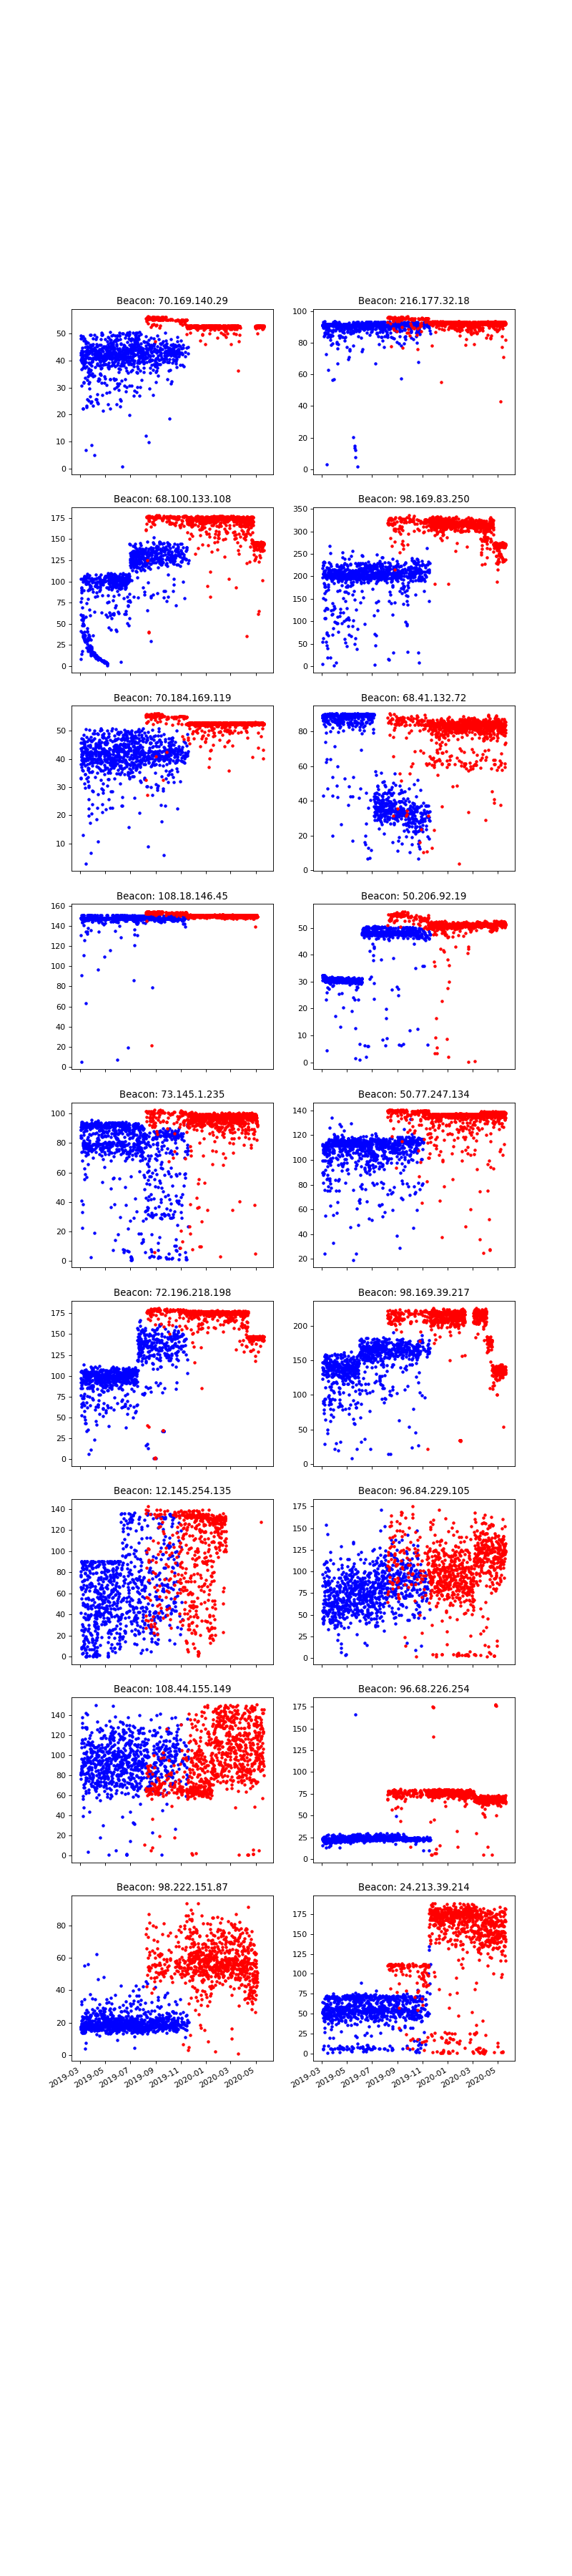

Beacon: 70.169.140.29
Beacon: 216.177.32.18
Beacon: 68.100.133.108
Beacon: 98.169.83.250
Beacon: 70.184.169.119
Beacon: 68.41.132.72
Beacon: 108.18.146.45
Beacon: 50.206.92.19
Beacon: 73.145.1.235
Beacon: 50.77.247.134
Beacon: 72.196.218.198
Beacon: 98.169.39.217
Beacon: 12.145.254.135
Beacon: 96.84.229.105
Beacon: 108.44.155.149
Beacon: 96.68.226.254
Beacon: 98.222.151.87
Beacon: 24.213.39.214


In [9]:
# lame
beacons = []
for t in stepbeacons['NDT5']:
    beacons.append(t['clientIP'])
plotMultiBeacons(beacons, 2, width=10)

In [7]:
# Particularly ugly, 
# plotMultiBeacons(['67.161.83.114'], 1, width=10)


In [8]:
SELECT
  COUNT (*) AS tests, 
  client.IP,
  MIN( test_date ) AS firstFast
FROM
  `measurement-lab.ndt.unified_downloads`
WHERE
  client.Geo.country_code = "US"
  AND client.Geo.region = "VA"
  AND a.MeanThroughputMbps > 100.0
  AND test_date > '2018-01-01'
GROUP BY client.IP
HAVING tests > 100
ORDER BY firstFast
LIMIT
  2000

IndentationError: unexpected indent (<ipython-input-8-ad3428ddc4fc>, line 2)